In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import xgboost as xgb
import yfinance as yf

In [2]:
# Download Microsoft stock data
ticker = "MSFT"
data = yf.download(ticker, start="2010-01-01", end="2025-01-01")

# Select relevant features
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Display the first few rows
print(data.head())

[*********************100%***********************]  1 of 1 completed

Price            Open       High        Low      Close    Volume
Ticker           MSFT       MSFT       MSFT       MSFT      MSFT
Date                                                            
2010-01-04  23.052244  23.413611  23.029658  23.300684  38409100
2010-01-05  23.225396  23.413608  23.067297  23.308208  49749600
2010-01-06  23.247977  23.398548  22.976953  23.165165  58182400
2010-01-07  23.059763  23.112464  22.728511  22.924252  50559700
2010-01-08  22.796270  23.247978  22.766155  23.082352  51197400


In [4]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define features (X) and target (y)
X = scaled_data[:, :-1]  # All columns except 'Close'
y = scaled_data[:, 3]    # 'Close' column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape data for LSTM (samples, timesteps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

c:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 0.0228 - val_loss: 0.0029
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 8.1307e-04 - val_loss: 7.7344e-04
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.1869e-04 - val_loss: 7.2499e-04
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.7752e-04 - val_loss: 1.3052e-04
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.9127e-04 - val_loss: 4.7791e-05
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.0063e-04 - val_loss: 5.9040e-04
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.3773e-04 - val_loss: 4.1118e-04
Epoch 8/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.0885e-04 - val_loss: 2.7602e-04
Epoch 9/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.5736e-04 - val_loss: 8.7061e-04
Epoch 10/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.1638e-04 - val_loss: 8.2862e-04
Epoch 11/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.0572e-04 - val_los

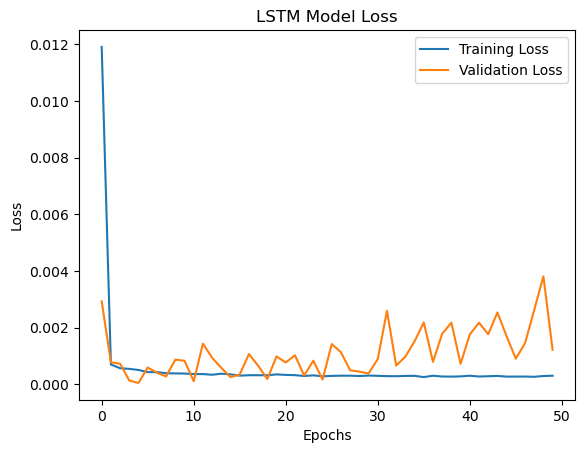

In [5]:
# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test), verbose=1)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [6]:
# Make predictions
y_pred_lstm = lstm_model.predict(X_test_lstm)

# Inverse transform the predictions
y_test_actual = scaler.inverse_transform(np.concatenate((X_test.reshape(X_test.shape[0], -1), y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_lstm_actual = scaler.inverse_transform(np.concatenate((X_test.reshape(X_test.shape[0], -1), y_pred_lstm.reshape(-1, 1)), axis=1))[:, -1]

# Calculate evaluation metrics
mse_lstm = mean_squared_error(y_test_actual, y_pred_lstm_actual)
mae_lstm = mean_absolute_error(y_test_actual, y_pred_lstm_actual)

print(f"LSTM Model - MSE: {mse_lstm}, MAE: {mae_lstm}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step
LSTM Model - MSE: 118514647872076.02, MAE: 8422068.635439938


In [7]:
# Train the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Inverse transform the predictions
y_pred_xgb_actual = scaler.inverse_transform(np.concatenate((X_test, y_pred_xgb.reshape(-1, 1)), axis=1))[:, -1]

# Calculate evaluation metrics
mse_xgb = mean_squared_error(y_test_actual, y_pred_xgb_actual)
mae_xgb = mean_absolute_error(y_test_actual, y_pred_xgb_actual)

print(f"XGBoost Model - MSE: {mse_xgb}, MAE: {mae_xgb}")

XGBoost Model - MSE: 1311753811651454.2, MAE: 22477212.253410343


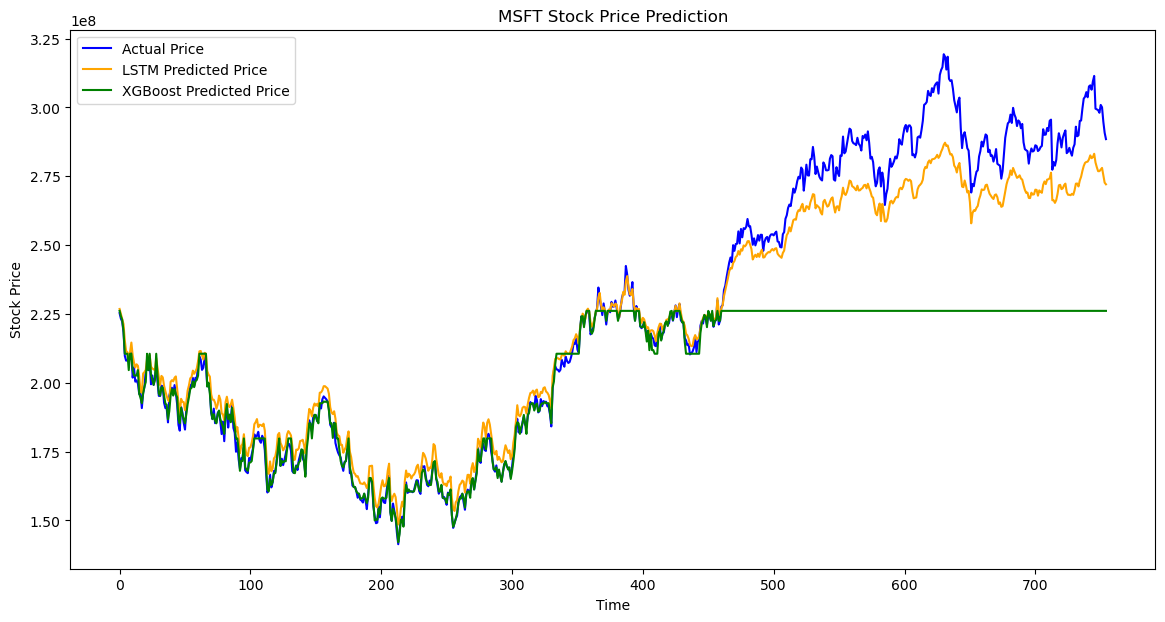

In [8]:
# Plot actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Actual Price', color='blue')
plt.plot(y_pred_lstm_actual, label='LSTM Predicted Price', color='orange')
plt.plot(y_pred_xgb_actual, label='XGBoost Predicted Price', color='green')
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

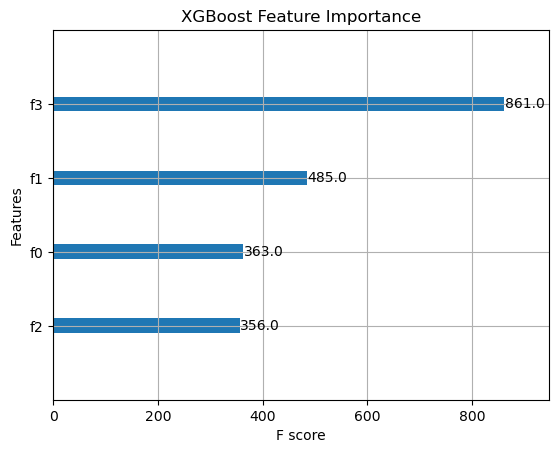

In [9]:
# Plot feature importance
xgb.plot_importance(xgb_model)
plt.title('XGBoost Feature Importance')
plt.show()